# Filter, normalize, and randomize our replicate datasets

12/11/16

In [84]:
import pandas as pd
import collections
import numpy as np
import csv

data_list_file = "raw_files/rep_file_list.txt"

data_list_df = pd.read_csv(data_list_file, sep="\t")

reps = data_list_df["Rep"].values
rep_files = data_list_df["File"].values
rep_dfs = [pd.read_csv(rep_file, sep="\t", index_col="gene") for rep_file in rep_files]

for rep, rep_df in zip(reps, rep_dfs):
    print rep
    print rep_df.shape
    print rep_df.head()

rep1
(17692, 12)
                    t00_rep1  t05_rep1   t1_rep1   t2_rep1   t3_rep1  \
gene                                                                   
ENSG00000279928.1   0.481816  0.494511  0.802590  0.548792  0.497908   
ENSG00000279457.2   1.114874  0.894085  0.922955  0.866655  0.933550   
ENSG00000187634.9   3.679652  3.735049  3.032186  3.003449  3.019709   
ENSG00000188976.9   3.804179  3.814503  3.738926  3.764058  3.679859   
ENSG00000187961.12  2.422637  2.110662  2.379013  2.192457  2.046370   

                     t4_rep1  t5_rep1_impute-linear  t6_rep1_impute-linear  \
gene                                                                         
ENSG00000279928.1   0.123292               0.214500               0.305707   
ENSG00000279457.2   0.952538               1.005223               1.057908   
ENSG00000187634.9   3.155739               3.210573               3.265408   
ENSG00000188976.9   3.803568               3.788290               3.773012   
ENSG000001

# filter by DEGs and TPM

In [85]:
filter_file = "raw_files/sig_genes_reg_fdr-0.05-all-ensg-cutoff-2-plusGR.txt"

filter_genes = set()
with open(filter_file) as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")
    for row in reader:
        filter_genes.add(row[0])

print "# genes to filter: ", len(filter_genes)
print list(filter_genes)[0:10]

# genes to filter:  2768
['ENSG00000116032.5', 'ENSG00000135272.8', 'ENSG00000103227.17', 'ENSG00000167578.15', 'ENSG00000042445.12', 'ENSG00000175854.10', 'ENSG00000146083.10', 'ENSG00000187288.9', 'ENSG00000129173.11', 'ENSG00000198663.15']


In [86]:
# Filter the dfs

f_rep_dfs = []

for rep, rep_df in zip(reps, rep_dfs):
    print rep
    print "Rep df size: ", rep_df.shape
    
    f_rep_df = rep_df[rep_df.index.isin(filter_genes)]
    print "Filtered size: ", f_rep_df.shape
    print f_rep_df.head()
    
    f_rep_dfs.append(f_rep_df)

rep1
Rep df size:  (17692, 12)
Filtered size:  (2768, 12)
                    t00_rep1  t05_rep1   t1_rep1   t2_rep1   t3_rep1  \
gene                                                                   
ENSG00000187583.9   1.627449  1.535524  1.478121  1.461917  1.183112   
ENSG00000131584.17  1.760448  1.838933  1.973829  1.926916  1.795740   
ENSG00000221978.10  4.013346  4.006069  4.473915  4.427144  4.253545   
ENSG00000116237.14  4.758080  4.738870  4.670027  4.711308  4.608537   
ENSG00000158292.6   1.061257  0.926990  1.966755  1.815870  1.618023   

                     t4_rep1  t5_rep1_impute-linear  t6_rep1_impute-linear  \
gene                                                                         
ENSG00000187583.9   1.396337               1.499097               1.601857   
ENSG00000131584.17  1.772573               1.839291               1.906009   
ENSG00000221978.10  4.193703               4.231618               4.269534   
ENSG00000116237.14  4.650614               4.60

In [99]:
if not os.path.exists("data/unnormalized"):
    os.makedirs("data/unnormalized")

out_files = ["data/unnormalized/" + rep_file.split("/")[1][:-4] + "-edgeR-reg-cutoff-2-plus-GR.txt" for rep_file in rep_files]
rand_out_files = [out_file[:-4] + "-rand.txt" for out_file in out_files]

out_list_file = "data/unnormalized/edgeR-reg-cutoff-2-plus-GR-reps.txt"
rand_out_list_file = out_list_file[:-4] + "-rand.txt"

with open(out_list_file, 'w') as csvfile:
    for out_file in out_files:
        csvfile.write(out_file.split("/")[-1] + "\n")
    
    print
    print "List of out files written to ", out_list_file
    print

with open(rand_out_list_file, 'w') as csvfile:
    for rand_out_file in rand_out_files:
        csvfile.write(rand_out_file.split("/")[-1] + "\n")
    
    print
    print "List of rand out files written to ", rand_out_list_file
    print


List of out files written to  data/unnormalized/edgeR-reg-cutoff-2-plus-GR-reps.txt


List of rand out files written to  data/unnormalized/edgeR-reg-cutoff-2-plus-GR-reps-rand.txt



In [88]:
# Randomize and save these out

import numpy as np
np.random.seed(123)


for rep, f_rep_df, out_file, rand_out_file in zip(reps, f_rep_dfs, out_files, rand_out_files):
    f_rep_matr = f_rep_df.as_matrix()
    
    
    f_rep_r_matr = np.array([np.random.choice(f_rep_matr[i], size = f_rep_matr.shape[1],\
                            replace=False) for i in range(f_rep_matr.shape[0])])

    f_rep_r_df = pd.DataFrame(data=f_rep_r_matr, index=f_rep_df.index, columns=f_rep_df.columns)
    
    print f_rep_r_df.head()
    
    
    print "----------------------"
    print rep
    
    
    f_rep_df.to_csv(out_file, sep="\t")
    
    print "df written to ", out_file

    
    f_rep_r_df.to_csv(rand_out_file, sep="\t")
    print 
    print "randomized df written to ", rand_out_file

!head -n 2 $out_file
!head -n 2 $rand_out_file
    
    
    

                    t00_rep1  t05_rep1   t1_rep1   t2_rep1   t3_rep1  \
gene                                                                   
ENSG00000187583.9   1.396337  1.627449  1.183112  1.500618  1.704618   
ENSG00000131584.17  1.839291  1.973829  1.772573  1.972728  1.795740   
ENSG00000221978.10  4.231618  4.323630  4.193703  4.498253  4.013346   
ENSG00000116237.14  4.517225  4.478813  4.758080  4.561688  4.670027   
ENSG00000158292.6   1.692674  1.974568  0.926990  1.618023  1.984760   

                     t4_rep1  t5_rep1_impute-linear  t6_rep1_impute-linear  \
gene                                                                         
ENSG00000187583.9   1.601857               1.337295               1.461917   
ENSG00000131584.17  1.926916               2.119733               1.906009   
ENSG00000221978.10  4.304324               4.307449               4.253545   
ENSG00000116237.14  4.484484               4.650614               4.738870   
ENSG00000158292.6   1.41078

# Center each at 0 mean.

In [89]:
fn_rep_dfs = []

print "NORMALIZATION"

for rep, f_rep_df in zip(reps, f_rep_dfs):
    print "*******************"
    print rep
    
    f_rep_matr = f_rep_df.as_matrix()
    
    mean = np.average(f_rep_matr, axis=1)
    
    fn_rep_matr = f_rep_matr - np.reshape(mean, (f_rep_matr.shape[0], 1))
    
    fn_rep_df = pd.DataFrame(data=fn_rep_matr, index=f_rep_df.index, columns=f_rep_df.columns)
    fn_rep_dfs.append(fn_rep_df)
    
    print rep
    print "Orig shape: ", f_rep_df.shape
    print f_rep_df.head()
    print
    print "New shape: ", fn_rep_df.shape
    print fn_rep_df.head()

NORMALIZATION
*******************
rep1
rep1
Orig shape:  (2768, 12)
                    t00_rep1  t05_rep1   t1_rep1   t2_rep1   t3_rep1  \
gene                                                                   
ENSG00000187583.9   1.627449  1.535524  1.478121  1.461917  1.183112   
ENSG00000131584.17  1.760448  1.838933  1.973829  1.926916  1.795740   
ENSG00000221978.10  4.013346  4.006069  4.473915  4.427144  4.253545   
ENSG00000116237.14  4.758080  4.738870  4.670027  4.711308  4.608537   
ENSG00000158292.6   1.061257  0.926990  1.966755  1.815870  1.618023   

                     t4_rep1  t5_rep1_impute-linear  t6_rep1_impute-linear  \
gene                                                                         
ENSG00000187583.9   1.396337               1.499097               1.601857   
ENSG00000131584.17  1.772573               1.839291               1.906009   
ENSG00000221978.10  4.193703               4.231618               4.269534   
ENSG00000116237.14  4.650614         

In [100]:
if not os.path.exists("data/0mean"):
    os.makedirs("data/0mean")

out_files = ["data/0mean/" + rep_file.split("/")[1][:-4] + "-edgeR-reg-cutoff-2-plus-GR-0mean.txt" for rep_file in rep_files]
rand_out_files = [out_file[:-4] + "-rand.txt" for out_file in out_files]

out_list_file = "data/0mean/edgeR-reg-cutoff-2-plus-GR-0mean-reps.txt"
rand_out_list_file = out_list_file[:-4] + "-rand.txt"

with open(out_list_file, 'w') as csvfile:
    for out_file in out_files:
        csvfile.write(out_file.split("/")[-1] + "\n")
    
    print
    print "List of out files written to ", out_list_file
    print

with open(rand_out_list_file, 'w') as csvfile:
    for rand_out_file in rand_out_files:
        csvfile.write(rand_out_file.split("/")[-1] + "\n")
    
    print
    print "List of rand out files written to ", rand_out_list_file
    print


List of out files written to  data/0mean/edgeR-reg-cutoff-2-plus-GR-0mean-reps.txt


List of rand out files written to  data/0mean/edgeR-reg-cutoff-2-plus-GR-0mean-reps-rand.txt



In [91]:
# Randomize and save these out

import numpy as np
np.random.seed(123)


fn_rep_r_dfs = []
for rep, fn_rep_df, out_file, rand_out_file in zip(reps, fn_rep_dfs, out_files, rand_out_files):

    fn_rep_matr  = fn_rep_df.as_matrix()
    
    fn_rep_r_matr = np.array([np.random.choice(fn_rep_matr[i], size = fn_rep_matr.shape[1],\
                            replace=False) for i in range(fn_rep_matr.shape[0])])

    fn_rep_r_df = pd.DataFrame(data=fn_rep_r_matr, index=fn_rep_df.index, columns=fn_rep_df.columns)
    
    fn_rep_r_dfs.append(fn_rep_r_df)
    
    print "----------------------"
    print rep
    
    
    fn_rep_df.to_csv(out_file, sep="\t")
    
    print "df written to ", out_file

    
    fn_rep_r_df.to_csv(rand_out_file, sep="\t")
    print 
    print "randomized df written to ", rand_out_file

!head -n 3 $out_file
!head -n 3 $rand_out_file

----------------------
rep1
df written to  data/0mean/featurecounts.genes.TPM.selected_rep1-impute-linear.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean.txt

randomized df written to  data/0mean/featurecounts.genes.TPM.selected_rep1-impute-linear.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean-rand.txt
----------------------
rep2
df written to  data/0mean/featurecounts.genes.TPM.selected_rep2.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean.txt

randomized df written to  data/0mean/featurecounts.genes.TPM.selected_rep2.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean-rand.txt
----------------------
rep3
df written to  data/0mean/featurecounts.genes.TPM.selected_rep3.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean.txt

randomized df written to  data/0mean/featurecounts.genes.TPM.selected_rep3.ln.surrogate_variables_corrected.

# Center each at 0 mean unit variance

In [92]:
fnv_rep_dfs = []

print "NORMALIZATION"

for rep, f_rep_df in zip(reps, f_rep_dfs):
    print "*******************"
    print rep
    
    f_rep_matr = f_rep_df.as_matrix()
    
    mean = np.average(f_rep_matr, axis=1)
    std = np.std(f_rep_matr, axis=1)
    
    fnv_rep_matr = (f_rep_matr - np.reshape(mean, (f_rep_matr.shape[0], 1)))/np.reshape(std, (f_rep_matr.shape[0], 1))
    
    fnv_rep_df = pd.DataFrame(data=fnv_rep_matr, index=f_rep_df.index, columns=f_rep_df.columns)
    fnv_rep_dfs.append(fnv_rep_df)

print rep
print "Orig shape: ", f_rep_df.shape
print f_rep_df.head()
print
print "New shape: ", fnv_rep_df.shape
print fnv_rep_df.head()

NORMALIZATION
*******************
rep1
*******************
rep2
*******************
rep3
*******************
rep4
rep4
Orig shape:  (2768, 12)
                    t00_rep4  t05_rep4   t1_rep4   t2_rep4   t3_rep4  \
gene                                                                   
ENSG00000187583.9   1.260751  1.346955  1.493414  1.297944  0.889432   
ENSG00000131584.17  1.699695  1.611825  1.662547  1.721354  1.693173   
ENSG00000221978.10  4.132147  4.132333  4.112194  4.255722  4.217372   
ENSG00000116237.14  4.673359  4.730797  4.759825  4.669493  4.627735   
ENSG00000158292.6   0.975671  1.157427  0.723527  1.257658  1.529894   

                     t4_rep4   t5_rep4   t6_rep4   t7_rep4   t8_rep4  \
gene                                                                   
ENSG00000187583.9   1.303826  1.108474  1.103537  1.427241  1.514516   
ENSG00000131584.17  1.613854  1.683424  1.849365  1.860673  1.865094   
ENSG00000221978.10  4.141379  4.191463  4.368464  4.221329  4.14

In [101]:
if not os.path.exists("data/0mean1var"):
    os.makedirs("data/0mean1var")

out_files = ["data/0mean1var/" + rep_file.split("/")[1][:-4] + "-edgeR-reg-cutoff-2-plus-GR-0mean1var.txt" for rep_file in rep_files]
rand_out_files = [out_file[:-4] + "-rand.txt" for out_file in out_files]

out_list_file = "data/0mean1var/edgeR-reg-cutoff-2-plus-GR-0mean1var-reps.txt"
rand_out_list_file = out_list_file[:-4] + "-rand.txt"

with open(out_list_file, 'w') as csvfile:
    for out_file in out_files:
        csvfile.write(out_file.split("/")[-1] + "\n")
    
    print
    print "List of out files written to ", out_list_file
    print

with open(rand_out_list_file, 'w') as csvfile:
    for rand_out_file in rand_out_files:
        csvfile.write(rand_out_file.split("/")[-1] + "\n")
    
    print
    print "List of rand out files written to ", rand_out_list_file
    print


List of out files written to  data/0mean1var/edgeR-reg-cutoff-2-plus-GR-0mean1var-reps.txt


List of rand out files written to  data/0mean1var/edgeR-reg-cutoff-2-plus-GR-0mean1var-reps-rand.txt



In [94]:
# Randomize and save these out

import numpy as np
np.random.seed(123)

fnv_rep_r_dfs = []
for rep, fnv_rep_df, out_file, rand_out_file in zip(reps, fnv_rep_dfs, out_files, rand_out_files):

    fnv_rep_matr  = fnv_rep_df.as_matrix()
    
    fnv_rep_r_matr = np.array([np.random.choice(fnv_rep_matr[i], size = fnv_rep_matr.shape[1],\
                            replace=False) for i in range(fnv_rep_matr.shape[0])])

    fnv_rep_r_df = pd.DataFrame(data=fnv_rep_r_matr, index=fnv_rep_df.index, columns=fnv_rep_df.columns)
    fnv_rep_r_dfs.append(fnv_rep_r_df)
    
    print "----------------------"
    print rep
    
    
    fnv_rep_df.to_csv(out_file, sep="\t")
    
    print "df written to ", out_file


    
    fnv_rep_r_df.to_csv(rand_out_file, sep="\t")
    print 
    print "randomized df written to ", rand_out_file

    
!head -n 2 $out_file
print
!head -n 2 $rand_out_file

----------------------
rep1
df written to  data/0mean1var/featurecounts.genes.TPM.selected_rep1-impute-linear.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean1var.txt

randomized df written to  data/0mean1var/featurecounts.genes.TPM.selected_rep1-impute-linear.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean1var-rand.txt
----------------------
rep2
df written to  data/0mean1var/featurecounts.genes.TPM.selected_rep2.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean1var.txt

randomized df written to  data/0mean1var/featurecounts.genes.TPM.selected_rep2.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean1var-rand.txt
----------------------
rep3
df written to  data/0mean1var/featurecounts.genes.TPM.selected_rep3.ln.surrogate_variables_corrected.protein_coding-edgeR-reg-cutoff-2-plus-GR-0mean1var.txt

randomized df written to  data/0mean1var/featurecounts.genes.TPM.sel

### get a small data subset from 0 mean unit variance

In [103]:
if not os.path.exists("small_data"):
    os.makedirs("small_data")

if not os.path.exists("small_data/0mean1var"):
    os.makedirs("small_data/0mean1var")

out_files = ["small_data/0mean1var/small_er-" + rep  + "-2cutoff-0mean-1var-" + str(small_size) + ".txt" for rep in reps]
rand_out_files = [out_file[:-4] + "-rand.txt" for out_file in out_files]

out_list_file = "small_data/0mean1var/small_er-reg-cutoff-2-plus-GR-0mean1var-reps.txt"
rand_out_list_file = out_list_file[:-4] + "-rand.txt"

with open(out_list_file, 'w') as csvfile:
    for out_file in out_files:
        csvfile.write(out_file.split("/")[-1] + "\n")
    
    print
    print "List of out files written to ", out_list_file
    print

with open(rand_out_list_file, 'w') as csvfile:
    for rand_out_file in rand_out_files:
        csvfile.write(rand_out_file.split("/")[-1] + "\n")
    
    print
    print "List of rand out files written to ", rand_out_list_file
    print


List of out files written to  small_data/0mean1var/small_er-reg-cutoff-2-plus-GR-0mean1var-reps.txt


List of rand out files written to  small_data/0mean1var/small_er-reg-cutoff-2-plus-GR-0mean1var-reps-rand.txt



In [98]:
import os

small_dfs = []
small_r_dfs = []


small_size = 100
    
for rep, fnv_rep_df, fnv_rep_r_df, out_file, rand_out_file in zip(reps, fnv_rep_dfs, fnv_rep_r_dfs, out_files, rand_out_files) :
    print rep
    
    small_df = fnv_rep_df.head(n=small_size)
    small_r_df = fnv_rep_r_df.head(n=small_size)
    
    small_df.to_csv(out_file, sep="\t")
    small_r_df.to_csv(rand_out_file, sep="\t")
    
    print out_file
    !wc -l $out_file
    !head -n 2 $out_file

    
    print rand_out_file
    !wc -l $rand_out_file
    !head -n 2 $rand_out_file
    
    print
    print



rep1
small_data/0mean1var/small_er-rep1-2cutoff-0mean-1var-100.txt
     101 small_data/0mean1var/small_er-rep1-2cutoff-0mean-1var-100.txt
gene	t00_rep1	t05_rep1	t1_rep1	t2_rep1	t3_rep1	t4_rep1	t5_rep1_impute-linear	t6_rep1_impute-linear	t7_rep1	t8_rep1	t10_rep1	t12_rep1
ENSG00000187583.9	1.04815007972	0.352525439292	-0.0818608831752	-0.204481903563	-2.31428472599	-0.700751823611	0.076868323232	0.854488470075	1.63210861699	0.0883757016359	-1.14753838638	0.396401091774
small_data/0mean1var/small_er-rep1-2cutoff-0mean-1var-100-rand.txt
     101 small_data/0mean1var/small_er-rep1-2cutoff-0mean-1var-100-rand.txt
gene	t00_rep1	t05_rep1	t1_rep1	t2_rep1	t3_rep1	t4_rep1	t5_rep1_impute-linear	t6_rep1_impute-linear	t7_rep1	t8_rep1	t10_rep1	t12_rep1
ENSG00000187583.9	-0.700751823611	1.04815007972	-2.31428472599	0.0883757016359	1.63210861699	0.854488470075	-1.14753838638	-0.204481903563	0.352525439292	0.076868323232	0.396401091774	-0.0818608831752


rep2
small_data/0mean1var/small_er-rep2-2cutoff-0

# IGNORE BELOW
# LET'S NOT NORMALIZE YET. Not enough variance
# Normalize all entries

Left off here -Jonathan 12/11/16

We only variance-scale those with std greater than one


rep1
Written to  plots/rep1-StdVSCount


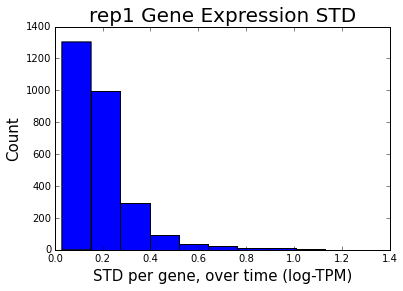

Written to  plots/rep1-MeanVSStd


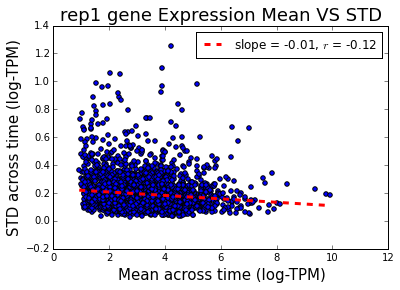

rep1
Orig shape:  (2767, 12)
                    t00_rep1  t05_rep1   t1_rep1   t2_rep1   t3_rep1  \
gene                                                                   
ENSG00000187583.9   1.627449  1.535524  1.478121  1.461917  1.183112   
ENSG00000131584.17  1.760448  1.838933  1.973829  1.926916  1.795740   
ENSG00000221978.10  4.013346  4.006069  4.473915  4.427144  4.253545   
ENSG00000116237.14  4.758080  4.738870  4.670027  4.711308  4.608537   
ENSG00000158292.6   1.061257  0.926990  1.966755  1.815870  1.618023   

                     t4_rep1  t5_rep1_impute-linear  t6_rep1_impute-linear  \
gene                                                                         
ENSG00000187583.9   1.396337               1.499097               1.601857   
ENSG00000131584.17  1.772573               1.839291               1.906009   
ENSG00000221978.10  4.193703               4.231618               4.269534   
ENSG00000116237.14  4.650614               4.606151               4.561688  

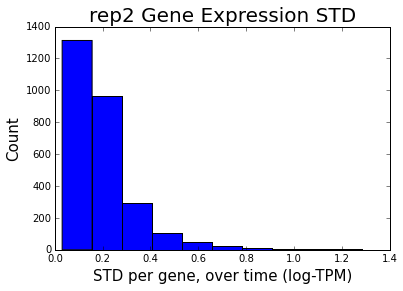

Written to  plots/rep2-MeanVSStd


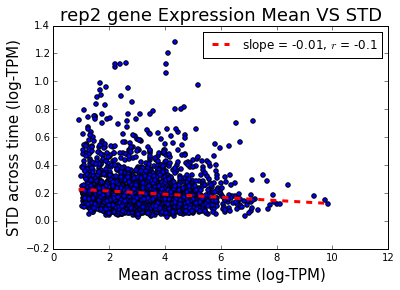

rep2
Orig shape:  (2767, 12)
                    t00_rep2plusextra  t05_rep2   t1_rep2   t2_rep2   t3_rep2  \
gene                                                                            
ENSG00000187583.9            1.414738  1.443238  1.518705  1.459472  1.283220   
ENSG00000131584.17           1.796899  1.764879  1.809972  1.938958  1.911634   
ENSG00000221978.10           4.175345  4.153773  4.292982  4.321826  4.333284   
ENSG00000116237.14           4.770995  4.698633  4.785688  4.682192  4.706197   
ENSG00000158292.6            0.954994  1.137736  1.066467  1.442878  1.838241   

                     t4_rep2   t5_rep2   t6_rep2   t7_rep2   t8_rep2  \
gene                                                                   
ENSG00000187583.9   1.298429  1.072534  1.449835  1.242136  1.604556   
ENSG00000131584.17  1.927313  1.813207  1.893946  1.824509  2.076064   
ENSG00000221978.10  4.372080  4.354310  4.342729  4.265637  4.351278   
ENSG00000116237.14  4.704025  4.698706  4.6

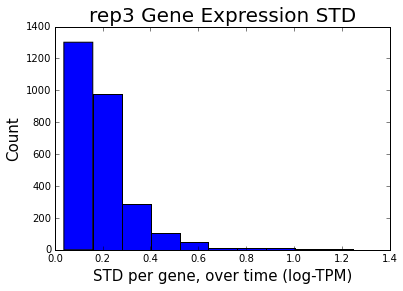

Written to  plots/rep3-MeanVSStd


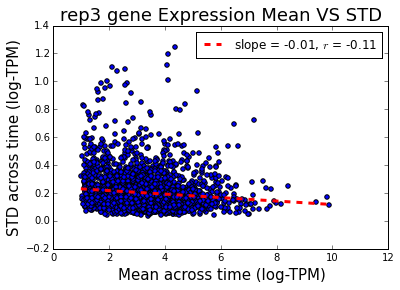

rep3
Orig shape:  (2767, 12)
                    t00_rep3plusextra  t05_rep3   t1_rep3   t2_rep3   t3_rep3  \
gene                                                                            
ENSG00000187583.9            1.578670  1.667278  1.422608  1.404475  1.226425   
ENSG00000131584.17           1.796887  2.029458  1.864149  1.815575  1.794215   
ENSG00000221978.10           4.112467  4.136799  4.215188  4.169479  4.218389   
ENSG00000116237.14           4.701398  4.713340  4.803435  4.649200  4.702338   
ENSG00000158292.6            1.211822  0.996787  0.950800  1.386691  2.027177   

                     t4_rep3   t5_rep3   t6_rep3   t7_rep3   t8_rep3  \
gene                                                                   
ENSG00000187583.9   1.470403  1.201870  1.322487  1.255826  1.540155   
ENSG00000131584.17  1.751171  1.611949  2.026675  1.846628  2.015336   
ENSG00000221978.10  4.112677  4.134107  4.336799  4.107849  4.341876   
ENSG00000116237.14  4.750015  4.703116  4.6

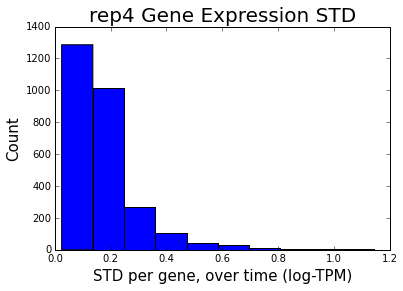

Written to  plots/rep4-MeanVSStd


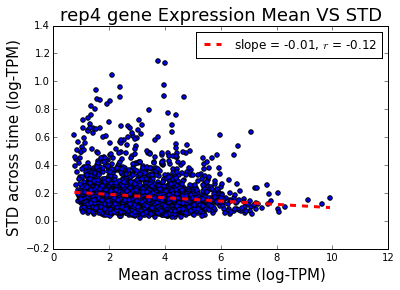

rep4
Orig shape:  (2767, 12)
                    t00_rep4  t05_rep4   t1_rep4   t2_rep4   t3_rep4  \
gene                                                                   
ENSG00000187583.9   1.260751  1.346955  1.493414  1.297944  0.889432   
ENSG00000131584.17  1.699695  1.611825  1.662547  1.721354  1.693173   
ENSG00000221978.10  4.132147  4.132333  4.112194  4.255722  4.217372   
ENSG00000116237.14  4.673359  4.730797  4.759825  4.669493  4.627735   
ENSG00000158292.6   0.975671  1.157427  0.723527  1.257658  1.529894   

                     t4_rep4   t5_rep4   t6_rep4   t7_rep4   t8_rep4  \
gene                                                                   
ENSG00000187583.9   1.303826  1.108474  1.103537  1.427241  1.514516   
ENSG00000131584.17  1.613854  1.683424  1.849365  1.860673  1.865094   
ENSG00000221978.10  4.141379  4.191463  4.368464  4.221329  4.149116   
ENSG00000116237.14  4.663668  4.695804  4.578604  4.586511  4.689974   
ENSG00000158292.6   1.862942  1.80

In [72]:
import matplotlib.pyplot as plt
from scipy import stats
import os

%matplotlib inline


fn_rep_dfs = []

for rep, f_rep_df in zip(reps, f_rep_dfs):
    
    f_rep_matr = f_rep_df.as_matrix()
    
    mean = np.average(f_rep_matr, axis=1)
    std = np.std(f_rep_matr, axis=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(mean, std)
    
    
    fn_rep_matr = (f_rep_matr - np.reshape(mean, (f_rep_matr.shape[0], 1)))/np.reshape(std, (f_rep_matr.shape[0], 1))
    
    fn_rep_df = pd.DataFrame(data=fn_rep_matr, index=f_rep_df.index, columns=f_rep_df.columns)
    
    
   
    
    # for a given replicate
    print rep
    
    plt.figure()
    plt.hist(std)
    plt.title(rep + " Gene Expression STD", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.ylabel("Count", fontsize=15)
    plt.xlabel("STD per gene, over time (log-TPM)", fontsize=15)
    plt.savefig("plots" + os.sep + rep + "-StdVSCount")
    print "Written to ", "plots" + os.sep + rep + "-StdVSCount"
    plt.show()
    plt.close()
    
    
    
    xs = np.linspace(np.min(mean), np.max(mean), 100)
    ys = xs * slope + intercept
    
    plt.figure()
    plt.scatter(mean, std)
    plt.plot(xs, ys, linestyle='dashed', color='r', \
            linewidth=3, \
             label="slope = " + str(round(slope, 2)) +  ", $r$ = " + str(round(r_value, 2)))
    plt.title(rep + " gene Expression Mean VS STD", fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel("Mean across time (log-TPM)", fontsize=15)
    plt.ylabel("STD across time (log-TPM)", fontsize=15)
    plt.legend()
    plt.savefig("plots" + os.sep + rep + "-MeanVSStd")
    print "Written to ", "plots" + os.sep + rep + "-MeanVSStd"
    plt.show()
    plt.close()
    
    
    
    
    
    print rep
    print "Orig shape: ", f_rep_df.shape
    print f_rep_df.head()
    print
    print "New shape: ", fn_rep_df.shape
    print fn_rep_df.head()




In [42]:
test_std = np.array([x if x > 1 else 1 for x in std ])
print test_std
print np.nonzero(test_std - 1)

[ 1.  1.  1. ...,  1.  1.  1.]
(array([ 388,  486, 1501, 2139]),)


In [35]:
print f_rep_matr
print f_rep_matr - np.reshape(mean, (f_rep_matr.shape[0], 1))
print (f_rep_matr - np.reshape(mean, (f_rep_matr.shape[0], 1)))/(np.reshape(std, (f_rep_matr.shape[0], 1)))

[[  1.62744929   1.53552432   1.47812131 ...,   1.50061763   1.33729484
    1.54132238]
 [  1.76044791   1.83893287   1.97382878 ...,   2.0213267    2.05540412
    2.11973301]
 [  4.01334611   4.00606902   4.47391497 ...,   4.32363007   4.30432379
    4.49825282]
 ..., 
 [  1.59667769   1.52977447   1.99705384 ...,   1.94938305   1.80488145
    2.06209915]
 [  9.92398341   9.40169824  10.00516269 ...,  10.05859241   9.96548645
   10.22311768]
 [  9.32088591   8.75712506   9.52780777 ...,   9.61998983   9.40733917
    9.66527812]]
[[ 0.13851027  0.04658531 -0.0108177  ...,  0.01167862 -0.15164418
   0.05238336]
 [-0.15479625 -0.07631129  0.05858462 ...,  0.10608254  0.14015996
   0.20448885]
 [-0.26186473 -0.26914181  0.19870414 ...,  0.04841924  0.02911296
   0.22304199]
 ..., 
 [-0.32896301 -0.39586623  0.07141315 ...,  0.02374235 -0.12075925
   0.13645845]
 [ 0.0123855  -0.50989967  0.09356478 ...,  0.1469945   0.05388854
   0.31151977]
 [-0.0587703  -0.62253115  0.14815156 ...,  0.2